In [4]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import copy 
import update 

import tqdm

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet

from update import LocalUpdate
from monai.utils import set_determinism
from utils import get_dataset,average_weights

import torch

print_config()

MONAI version: 0.5.2+24.g2a4c9e5
Numpy version: 1.19.2
Pytorch version: 1.8.0a0+52ea372
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: 2a4c9e514bbc603191e49120e9d598a9414c0e75

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 8.2.0
Tensorboard version: 1.15.0+nv
gdown version: 3.13.0
TorchVision version: 0.9.0a0
ITK version: 5.1.2
tqdm version: 4.53.0
lmdb version: 1.1.1
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
#from tensorboardX import SummaryWriter

path_project = os.path.abspath('..')
#logger = SummaryWriter('../logs')
logger=0
os.environ["MONAI_DATA_DIRECTORY"]="/data"  
root_dir = os.environ.get("MONAI_DATA_DIRECTORY")

#args = args_parser()
epochs = 30
num_users = 1
frac = 1 
local_ep = 1
local_bs = 2
lr = 1e-4
momentum = 0.5
iid=1
dataset="brats"
#exp_details(args)

device = torch.device("cuda:0")



In [3]:
print(local_ep)

1


In [6]:
set_determinism(seed=0)

In [7]:
import importlib
import utils
importlib.reload(utils)
from utils import get_dataset

In [8]:
#Load Datasets
train_dataset, val_dataset, user_groups_train, user_groups_val = get_dataset(iid, num_users)


Loading dataset:   0%|          | 0/100 [00:00<?, ?it/s]

/data


Loading dataset: 100%|██████████| 96/96 [01:46<00:00,  1.11s/it]


96


In [7]:
for key,value in user_groups_train.items():
    print(key,value)
for key,value in user_groups_val.items():
    print(key,value)
#print(len(train_dataset))

0 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 22

In [3]:
print(f"image shape: {train_dataset[2]['image'].shape}")
print(type(train_dataset[2]['image']))

NameError: name 'train_dataset' is not defined

In [9]:

#Build model
global_model = UNet(
    dimensions=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)


In [34]:
import importlib
import update
importlib.reload(update)
from update import LocalUpdate
import utils
importlib.reload(utils)
from utils import average_weights

In [35]:
##### global_model.to(device)
global_model.train()

#print(global_model)

# copy weights
global_weights = global_model.state_dict()

# Training
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 1
val_loss_pre, counter = 0, 0


#####
best_metric = -1
best_metric_epoch = -1
#epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

metric, metric_tc, metric_wt, metric_et=0.0,0.0,0.0,0.0

for epoch in tqdm.tqdm(range(epochs)):
        
    local_weights, local_losses = [], []
    
    print(f'\n | Global Training Round : {epoch+1} |\n')

    global_model.train()
    m = max(int(frac * num_users), 1)
    idxs_users = np.random.choice(range(num_users), m, replace=False)

    for idx in idxs_users:
        
        print(f"user {idx} selected")
        local_model = LocalUpdate(train_dataset=train_dataset, val_dataset=val_dataset,
                                  train_idxs=user_groups_train[idx],val_idxs=user_groups_val[idx], logger=logger, local_bs=local_bs, lr=lr, local_ep=local_ep)
        w, loss = local_model.update_weights(
                model=copy.deepcopy(global_model), global_round=epoch)
        local_weights.append(copy.deepcopy(w))
      #  local_losses.append(copy.deepcopy(loss))
        local_losses.append(loss)
     #   global_model.load_state_dict(copy.deepcopy(w))
    
     #   global_model.eval()
        
     #   local_model.inference(model=global_model)

    # update global weights
    global_weights = average_weights(local_weights)
   ## global_weights = local_weights[0]
    
    # update global loss
    global_model.load_state_dict(global_weights)
    
    for c in range(num_users):
        local_model = LocalUpdate(train_dataset=train_dataset, val_dataset=val_dataset,
                                    train_idxs=user_groups_train[c],val_idxs=user_groups_val[c], logger=logger, lr=lr, local_ep=local_ep, local_bs=local_bs)
        local_model.inference(model=global_model)
    
    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)
    print(f"current epoch: {epoch + 1} current epoch loss: {loss_avg:.4f}")
    # Calculate avg training accuracy over all users at every epoch
    
   # list_acc, list_loss = [], []
    ep_metric_values = []
    ep_metric_values_tc = []
    ep_metric_values_wt = []
    ep_metric_values_et = []

    for c in range(num_users):
        local_model = LocalUpdate(train_dataset=train_dataset, val_dataset=val_dataset,
                                    train_idxs=user_groups_train[c],val_idxs=user_groups_val[c], logger=logger, lr=lr, local_ep=local_ep, local_bs=local_bs)
        metric, metric_tc, metric_wt, metric_et=local_model.inference(model=global_model)
        
        ep_metric_values.append(metric)
        ep_metric_values_tc.append(metric_tc)
        ep_metric_values_wt.append(metric_wt) 
        ep_metric_values_et.append(metric_et) 

    metric = sum(ep_metric_values)/len(ep_metric_values)
    metric_tc = sum(ep_metric_values_tc)/len(ep_metric_values_tc)
    metric_wt = sum(ep_metric_values_wt)/len(ep_metric_values_wt)
    metric_et = sum(ep_metric_values_et)/len(ep_metric_values_et)
    metric_values.append(metric)
    metric_values_tc.append(metric_tc)
    metric_values_wt.append(metric_wt)
    metric_values_et.append(metric_et)

    global_model.eval()
  ###  for c in range(num_users):
  ###      local_model = LocalUpdate(train_dataset=train_dataset, val_dataset=val_dataset,
  ###                                    train_idxs=user_groups_train[c],val_idxs=user_groups_val[c], logger=logger, lr=lr, local_ep=local_ep, local_bs=local_bs)
  ###      metric, metric_tc, metric_wt, metric_et = local_model.inference(model=global_model)
         
   ##    print(metric)
   ##    ep_metric_values.append(metric)
   ##     ep_metric_values_tc.append(metric_tc)
   ##     ep_metric_values_wt.append(metric_wt) 
   ##     ep_metric_values_et.append(metric_et) 

        
   # train_accuracy.append(sum(list_acc)/len(list_acc))
##    metric = sum(ep_metric_values)/len(ep_metric_values)
    print(metric)
##    metric_tc = sum(ep_metric_values_tc)/len(ep_metric_values_tc)
##    metric_wt = sum(ep_metric_values_wt)/len(ep_metric_values_wt)
##    metric_et = sum(ep_metric_values_et)/len(ep_metric_values_et)
##    metric_values.append(metric)
##    metric_values_tc.append(metric_tc)
##    metric_values_wt.append(metric_wt)
##    metric_values_et.append(metric_et)
    
    if metric > best_metric:
         
        best_metric = metric
        best_metric_epoch = epoch + 1
        torch.save(
                global_model.state_dict(),
                os.path.join(root_dir, "best_metric_model.pth"),
        )
        print("saved new best metric model")


    # print global training loss after every 'i' rounds
    if (epoch+1) % print_every == 0:
      #  print(f' \nAvg Training Stats after {epoch+1} global rounds:')
      #  print(f'Training Loss : {np.mean(np.array(train_loss))}')
      #  print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))
         print(
            f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
            f"\nbest mean dice: {best_metric:.4f}"
            f" at epoch: {best_metric_epoch}"
         )



  0%|          | 0/30 [00:00<?, ?it/s]


 | Global Training Round : 1 |

user 0 selected
local epoch 1


  0%|          | 0/30 [00:13<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [31]:
######i(global_weights['model.0.conv.unit0.conv.weight']== local_weights[0]['model.0.conv.unit0.conv.weight'])

TypeError: 'tuple' object is not callable

In [27]:
#if(global_weights['model.0.conv.unit0.conv.weight']== local_weights[0]['model.0.conv.unit0.conv.weight']):
#print(local_weights[0])
for i,j in zip(local_weights[0].items(), global_weights.items()):
    if(not torch.all(i.eq(j))):
        print("err")
        break

AttributeError: 'tuple' object has no attribute 'eq'

In [20]:
print(train_loss)

[0.9236187298887784, 0.8995381341767066, 0.8955848908301481, 0.8878089926906467, 0.880147048800262, 0.8727054104362566, 0.8638185824930054, 0.8599327664399884, 0.8502822527565908, 0.8536691499739578, 0.8535233665372908, 0.8549118253988089, 0.8525141772535658, 0.8474841339072001, 0.8461131041811913, 0.8574099254976842, 0.8503547200222605, 0.8558843575187565, 0.8510606436385322, 0.8579111200632509, 0.8488730373456306, 0.854572138528234, 0.8497037177847833, 0.846711975397523, 0.8415661426549105, 0.8468217739124888, 0.8474959666581497, 0.8480157326791704, 0.8514783594411673, 0.854346740184371, 0.8533474885925805, 0.8560702395193356, 0.8537393476545196, 0.8460496197041777, 0.8456165317407588, 0.8554071906915645, 0.8527106777908876, 0.8477472767387468, 0.847437611867472, 0.845639591057276, 0.8447553500072243, 0.8481403202125707, 0.8535542767686942, 0.848668247461319, 0.8420711436222509, 0.8445428047598023, 0.8469950307890312, 0.843997999872129, 0.8458892211471636, 0.8459518388989046, 0.84354

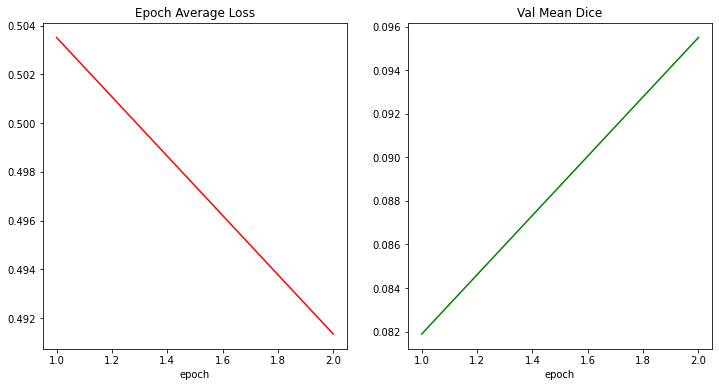

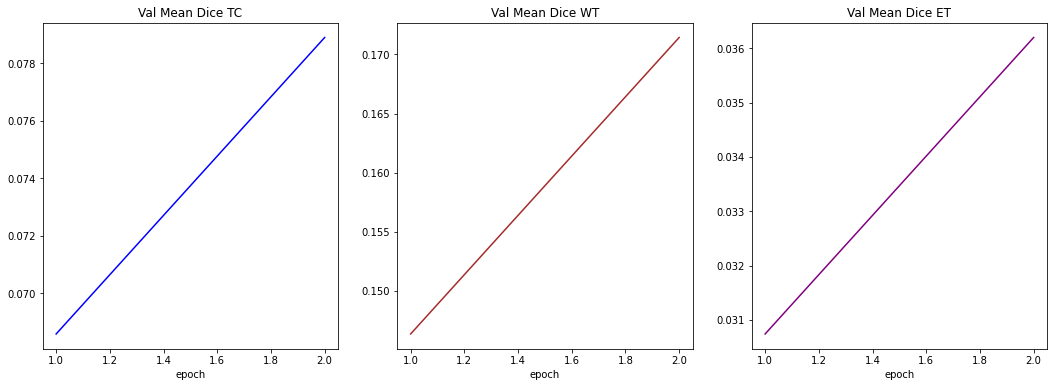

In [18]:
%matplotlib inline 
val_interval=1
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

In [ ]:
test_acc, test_loss = test_inference(args, global_model, test_dataset)
    
print(f' \n Results after {epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))

    # Saving the objects train_loss and train_accuracy:
file_name = '../save/objects/{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}].pkl'.\
    format(dataset, model, epochs, frac, iid,
            local_ep, local_bs)

with open(file_name, 'wb') as f:
    pickle.dump([train_loss, train_accuracy], f)

print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))




In [163]:
#PLOTTING (optional)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

# Plot Loss curve
plt.figure()
model = "UNET"
plt.title('Training Loss vs Communication rounds')
plt.plot(range(len(train_loss)), train_loss, color='r')
plt.ylabel('Training loss')
plt.xlabel('Communication Rounds')
plt.savefig('../save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_loss.png'.
             format(dataset, model, epochs, frac,
                        iid, local_ep, local_bs))
    
# # Plot Average Accuracy vs Communication rounds
plt.figure()
plt.title('Average Accuracy vs Communication rounds')
plt.plot(range(len(train_accuracy)), train_accuracy, color='k')
plt.ylabel('Average Accuracy')
plt.xlabel('Communication Rounds')
plt.savefig('../save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_acc.png'.
             format(dataset, model, epochs, frac,
                    iid, local_ep, local_bs))

FileNotFoundError: [Errno 2] No such file or directory: '../save/fed_brats_UNET_1_C[0.1]_iid[1]_E[1]_B[2]_loss.png'